<a href="https://colab.research.google.com/github/ErSKS/Colab/blob/main/06_Finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import PIL

import keras
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.applications.vgg19 import preprocess_input, decode_predictions
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from keras import activations

from vis.utils import utils
from vis.visualization import visualize_saliency, overlay
from vis.visualization import visualize_cam

from sklearn.metrics import confusion_matrix
from quiver_engine import server

%matplotlib inline

### Define functions

In [ ]:
def set_trainable(model, flag=False):
    for layer in model.layers:
        layer.trainable = flag
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [ ]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [ ]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [ ]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [ ]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

In [ ]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [ ]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = transfer_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [ ]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = pre_model.predict(img_array)
    
    # Decode the output of the VGG16 model.
    pred_decoded = decode_predictions(pred)[0]

    # Print the predictions.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

In [ ]:
def predict_transferred(model,image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)
    #cls_pred = np.argmax(pred,axis=1)
    print("Rs.10: {0}, Rs.20: {1}".format(pred[0][0]*100, pred[0][1]*100))
    
    # Decode the output of the VGG16 model.
    #pred_decoded = decode_predictions(pred)[0]

    # Print the predictions.
    #for code, name, score in pred_decoded:
        #print("{0:>6.2%} : {1}".format(score, name))

In [ ]:
def predict_only(model,image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    #Make Predictions
    pred = model.predict(img_array)
    
    if(pred[0][0] > pred[0][1]):
        print("Rs.10")
    else:
        print("Rs.20")

### Architecture

In [ ]:
pre_model = keras.applications.vgg19.VGG19(include_top=True, weights='imagenet')

In [ ]:
pre_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
last_conv_block = pre_model.get_layer('block5_pool')
last_conv_block.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [ ]:
ref_model = Model(inputs=pre_model.input, outputs=last_conv_block.output)

In [ ]:
set_trainable(ref_model, flag=False)

False:	input_2
False:	conv1
False:	bn_conv1
False:	activation_50
False:	max_pooling2d_2
False:	res2a_branch2a
False:	bn2a_branch2a
False:	activation_51
False:	res2a_branch2b
False:	bn2a_branch2b
False:	activation_52
False:	res2a_branch2c
False:	res2a_branch1
False:	bn2a_branch2c
False:	bn2a_branch1
False:	add_17
False:	activation_53
False:	res2b_branch2a
False:	bn2b_branch2a
False:	activation_54
False:	res2b_branch2b
False:	bn2b_branch2b
False:	activation_55
False:	res2b_branch2c
False:	bn2b_branch2c
False:	add_18
False:	activation_56
False:	res2c_branch2a
False:	bn2c_branch2a
False:	activation_57
False:	res2c_branch2b
False:	bn2c_branch2b
False:	activation_58
False:	res2c_branch2c
False:	bn2c_branch2c
False:	add_19
False:	activation_59
False:	res3a_branch2a
False:	bn3a_branch2a
False:	activation_60
False:	res3a_branch2b
False:	bn3a_branch2b
False:	activation_61
False:	res3a_branch2c
False:	res3a_branch1
False:	bn3a_branch2c
False:	bn3a_branch1
False:	add_20
False:	activation_62
False:

In [ ]:
transfer_model = keras.models.Sequential()

In [ ]:
transfer_model.add(ref_model)

In [ ]:
transfer_model.add(Flatten())

In [ ]:
transfer_model.add(Dense(1024, activation='relu'))

In [ ]:
transfer_model.add(Dense(2, activation='softmax'))

In [ ]:
transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 45,717,570
Trainable params: 45,717,570
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = Adam(lr=1e-5)

In [ ]:
loss = 'categorical_crossentropy'

In [ ]:
metrics = ['categorical_accuracy']

In [ ]:
transfer_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255)

In [ ]:
train_dir = 'data_20/train/'
test_dir = 'data_20/valid/'

In [ ]:
input_shape = pre_model.layers[0].output_shape[1:3]
input_shape

(224, 224)

In [ ]:
batch_size = 1

In [ ]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

Found 40 images belonging to 2 classes.


In [ ]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 8 images belonging to 2 classes.


In [ ]:
epochs = 3
steps_per_epoch = 40

In [ ]:
steps_test = 8
steps_test

8

In [ ]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [ ]:
cls_train = generator_train.classes
cls_test = generator_test.classes

In [ ]:
class_names = list(generator_train.class_indices.keys())
class_names

['ten', 'twenty']

In [ ]:
# num_classes = generator_train.num_classes
num_classes = 2

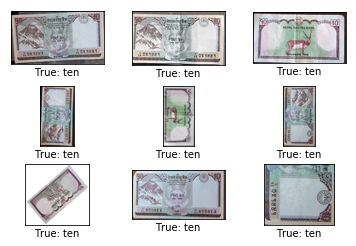

In [ ]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

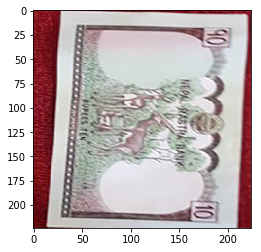

20.45% : handkerchief
15.71% : wallet
10.20% : purse
 7.03% : paper_towel
 4.58% : face_powder


In [ ]:
predict(image_path=train_dir+"/ten/ten_1.jpg")

In [ ]:
history = transfer_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/3
40/40 [==============================] - 168s - loss: 0.5664 - categorical_accuracy: 0.7250 - val_loss: 0.3375 - val_categorical_accuracy: 1.0000
Epoch 2/3
40/40 [==============================] - 166s - loss: 0.2489 - categorical_accuracy: 0.9750 - val_loss: 0.5292 - val_categorical_accuracy: 0.7500
Epoch 3/3
40/40 [==============================] - 162s - loss: 0.1065 - categorical_accuracy: 0.9750 - val_loss: 0.2608 - val_categorical_accuracy: 0.8750


In [ ]:
transfer_model.save('transfer_workshop_2.model')

In [ ]:
transfer_model.save_weights('transfer_weights_workshop_2.hdf5')

In [ ]:
# transfer_model.load_weights('finetune_weights_3.hdf5')

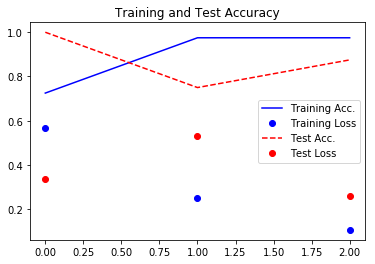

In [ ]:
plot_training_history(history)

In [ ]:
# transfer_model = keras.models.load_model('finetune_13.model')

In [ ]:
result = transfer_model.evaluate_generator(generator_test, steps=steps_test)

In [ ]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 87.50%


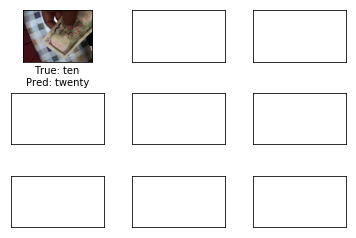

Confusion matrix:
[[3 1]
 [0 4]]
(0) ten
(1) twenty


In [ ]:
example_errors()

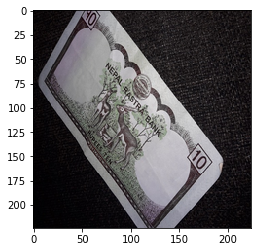

Rs.10: 100.0, Rs.20: 0.0


In [ ]:
predict_transferred(transfer_model, image_path='data/train/ten/ten_2414.jpg')

In [ ]:
set_trainable(ref_model, True)

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_conv4
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_conv4
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_conv4
True:	block5_pool


In [ ]:
transfer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 45,717,570
Trainable params: 45,717,570
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer_fine = Adam(lr=1e-7)

In [ ]:
transfer_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

In [ ]:
history = transfer_model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

Epoch 1/3
40/40 [==============================] - 165s - loss: 0.0569 - categorical_accuracy: 0.9500 - val_loss: 0.2045 - val_categorical_accuracy: 0.8750
Epoch 2/3
40/40 [==============================] - 163s - loss: 0.0354 - categorical_accuracy: 1.0000 - val_loss: 0.1643 - val_categorical_accuracy: 0.8750
Epoch 3/3
40/40 [==============================] - 163s - loss: 0.0064 - categorical_accuracy: 1.0000 - val_loss: 0.1487 - val_categorical_accuracy: 0.8750


In [ ]:
# transfer_model.load_weights('finetune_workshop_2.model')

In [ ]:
transfer_model.save_weights('finetune_workshop_weights__1.hdf5')

In [ ]:
transfer_model.save('finetune_workshop__1.model')